In [1]:
import sys
import os
sys.path.append('..')


import torch

from manga_ocr.utils import get_path_project_dir
from manga_ocr.utils.pytorch_model import get_total_parameters_count

# Load/Prepare model

In [2]:
from manga_ocr.models.localization.conv_unet.conv_unet import ConvUnet

path_output_model = get_path_project_dir('data/output/models/localization.bin')
print('path_output_model', os.path.abspath(path_output_model))

if os.path.exists(path_output_model):
    print('Loading an existing model...')
    model = torch.load(path_output_model)
else:
    print('Creating a new model...')
    model = ConvUnet()
    
print(model)

path_output_model /Users/wanasit/Dropbox/Workspace_Personal/manga-ocr/data/output/models/localization.bin
Loading an existing model...
ConvUnet(
  (down_conv_3): ConvWithPoolingToHalfSize(
    (conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (down_conv_2): ConvWithPoolingToHalfSize(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (down_conv_1): ConvWithPoolingToHalfSize(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): 

In [3]:
print(model.preferred_image_size)
print(get_total_parameters_count(model))

(500, 500)
404563


## Load/Prepare Dataset

In [4]:
from manga_ocr.models.localization.localization_dataset import LocalizationDataset

path_dataset = get_path_project_dir('data/output/generate_manga_dataset')
print('path_dataset', os.path.abspath(path_dataset))

dataset = LocalizationDataset.load_generated_manga_dataset(path_dataset, image_size=model.preferred_image_size)
print('dataset', len(dataset))

path_dataset /Users/wanasit/Dropbox/Workspace_Personal/manga-ocr/data/output/generate_manga_dataset
dataset 4000


In [5]:
validation_dataset = dataset.subset(to_idx=100)
training_dataset = dataset.subset(from_idx=100)
print('validation_dataset', len(validation_dataset))
print('training_dataset', len(training_dataset))

validation_dataset 100
training_dataset 3900


# Training

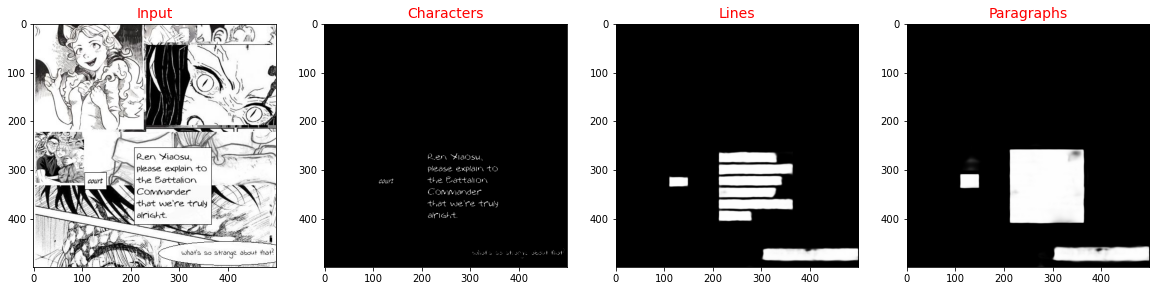

In [6]:
from manga_ocr.models.localization.train import train
from manga_ocr.utils.ploting import plot_losses, show_images
from IPython.display import clear_output

def show_example(model, img):
    mask_char, mask_line, mask_paragraph = model.create_output_marks(img)
    show_images(
        images=[img, mask_char, mask_line, mask_paragraph], 
        texts=['Input', 'Characters', 'Lines', 'Paragraphs'], 
        figsize=(20, 20), num_col=4
    )


def save_and_report(i_epoch, train_losses, val_losses):
    clear_output()
    plot_losses(train_losses, val_losses)
    show_example(model, training_dataset.images[0])
    show_example(model, validation_dataset.images[0])
    
    torch.save(model, path_output_model)
    
    
show_example(model, training_dataset.images[0])

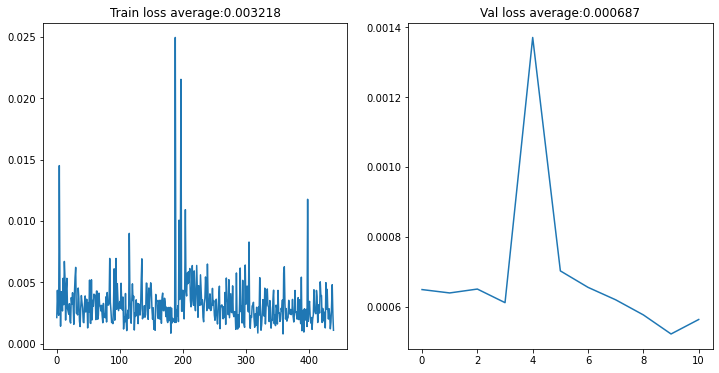

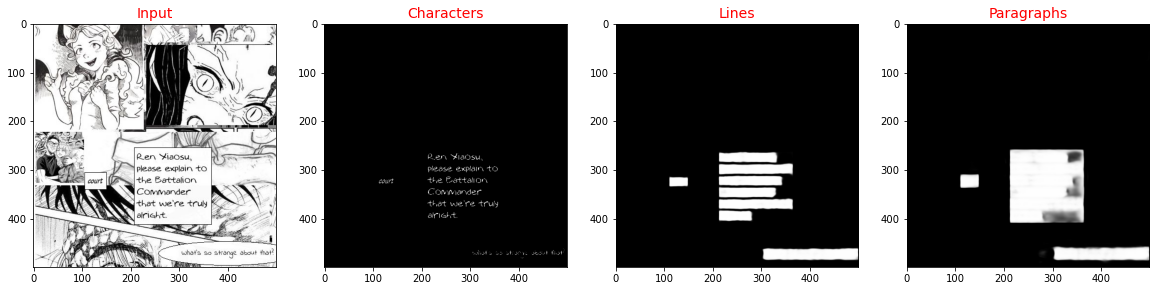

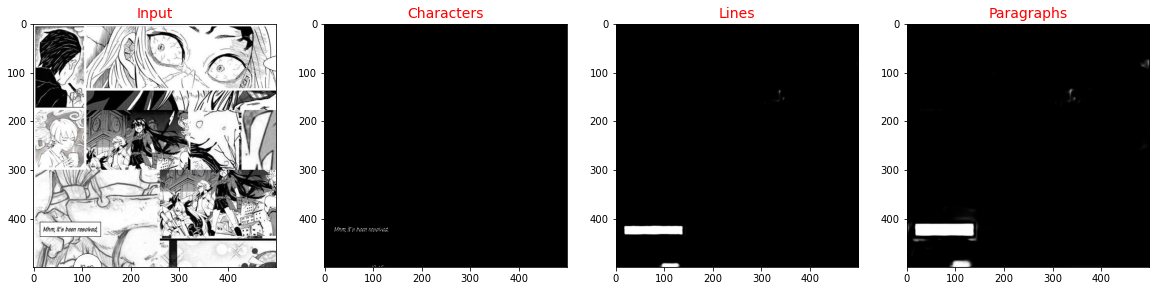

Epoch 0:  56%|▌| 2200/3900 [44:47<1:34:09,  3.32s/it, current_batch_loss=0.00108, validation_loss=0.000563]

In [ ]:
train(model,
      train_dataset=training_dataset,
      validate_dataset=validation_dataset,
      validate_every_n=200,
      update_callback=save_and_report,
      update_every_n=200,
      batch_size=5,
      epoch_count=3)